В этом блоке проанализируем А/Б тест

Мы добавили на лендинг с оформлением дебетовой карты (https://www.tinkoff.ru/cards/debit-cards/tinkoff-black/) информацию о дополнительных кэшбеках, которые появляются благодаря нашим патнерам. Рассчитываем, что это вырастит конверсию из переходов на лендинг в оформление дебетовой карты. 

В приложенном файле вам доступны логи переходов на сайт и последующего оформления карточки за каждый день. 

In [105]:
# загрузим необходимые пакеты

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

sns.set()

In [3]:
# Загрузите таблицу в датафрейм

df = pd.read_csv('hw_ab.csv')

In [6]:
# Посмотрите на поля и проанализируйте таблицу: она содержит поля 
# date — дата захода пользователя на лендинг
# id — идентификатор, присвоенный пользователю
# group — группа теста или контроля
# converted – 1, если пользователь оформил карточку и 0, если не оформил
df.head()


,date,id,group,converted
0,2023-08-01,5030836,control,0
1,2023-08-01,5091425,control,0
2,2023-08-01,5106537,control,0
3,2023-08-01,4556522,control,0
4,2023-08-01,4002917,control,0


In [10]:
# убедитесь,что пользователи уникальные
print(df[df['id'].isna()])

Empty DataFrame
Columns: [date, id, group, converted]
Index: []


In [11]:
print(df.shape[0], df['id'].nunique())

94778 94778


In [14]:
# убедитесь, что пользователей в тесте и контрле приблизительно равное количество, 
# в каждой группе каждый день теста были пользователи, и они как оформляли карту, так и нет
df['group'].value_counts()

group
test       47448
control    47330
Name: count, dtype: int64

In [41]:
df_pivot = df.loc[:, ['date', 'group']].value_counts().reset_index()
df_pivot = df_pivot.pivot(index='date', columns='group', values='count')
df_pivot['diff'] = (df_pivot['control'] - df_pivot['test']).abs()
print(df_pivot.loc[df_pivot['diff'].idxmax()], end='\n\n')
print(df_pivot['diff'].mean())

group
control    464
test       530
diff        66
Name: 2023-10-24, dtype: int64

15.870967741935484


In [43]:
# отличаются ли конверсии в тесте и в контроле?
df.loc[:, ['group', 'converted']].value_counts().reset_index()


,group,converted,count
0,control,0,42408
1,test,0,41774
2,test,1,5674
3,control,1,4922


In [44]:
# конверсия в контроле: 
4922 / (4922 + 42408)

0.10399323896049018

In [45]:
# конверсия в тесте: 
5674 / (5674 + 41774)

0.11958354409037261

In [47]:
# отношение конверсий: 

conv_test = df[df['group'] == 'test'].loc[:, 'converted'].sum()   # посчитайте число открытых карт в тесте
seen_test = df[df['group'] == 'test'].loc[:, 'converted'].count()   # посчитайте общее число наблюдений в тесте, это число заходов на лендинг

conv_control = df[df['group'] == 'control'].loc[:, 'converted'].sum()   # посчитайте число открытых карт в контроле
seen_control = df[df['group'] == 'control'].loc[:, 'converted'].count()   # посчитайте общее число наблюдений в контроле, это число заходов на лендинг

print((conv_test/seen_test)/(conv_control/seen_control)-1)

0.14991652616768292
5674 47448 4922 47330


In [ ]:
# значимо ли это отличие? 
# проверьте статистическим тестом

In [54]:
# сначала используем знание о том, что конверсии распределены биномиально: 
# используйте статистический тест и проинтерпретируйте результаты
# как меняется ваш результат в зависимости от принятого вами уровня значимости?

from scipy.stats import binomtest

binomtest(conv_test, seen_test, conv_control/seen_control) 

BinomTestResult(k=5674, n=47448, alternative='two-sided', statistic=0.11958354409037261, pvalue=1.2376571667780677e-27)

In [62]:
# достаточно ли длинным был тест, чтобы мы могли посчитать средние конверсии и сравнить значимость их различия? 
# посчитайте количество дней теста, убедитесь, что среди них нет пропусков

df['date'] = pd.to_datetime(df['date'])
print(df['date'].nunique())

93


In [68]:
dates = pd.DataFrame(df['date'].unique(), columns=['date'])

In [76]:
(dates['date'].shift(-1) - dates['date']).max()

Timedelta('1 days 00:00:00')

In [91]:
# посчитайте количество открытых карт и средние конверсии по дням в тесте и в контроле:

test_n_by_date = df[df['group'] == 'test'].loc[:, ['date', 'converted']].groupby(['date']).sum()   # посчитайте количество открытых карт и средние конверсии по дням в тесте
control_n_by_date = df[df['group'] == 'control'].loc[:, ['date', 'converted']].groupby(['date']).sum()   # посчитайте количество открытых карт и средние конверсии по дням в контроле


In [100]:
# посчитайте конверсию из посещений в оформленние карт по дням
test_conv_by_date = df[df['group'] == 'test'].loc[:, ['date', 'converted']].groupby(['date']).mean()   # посчитайте конверсию из посещений в оформленние карт по дням в тесте
control_conv_by_date = df[df['group'] == 'control'].loc[:, ['date', 'converted']].groupby(['date']).mean()   # посчитайте конверсию из посещений в оформленние карт по дням в контроле


(0.0, 100.0)

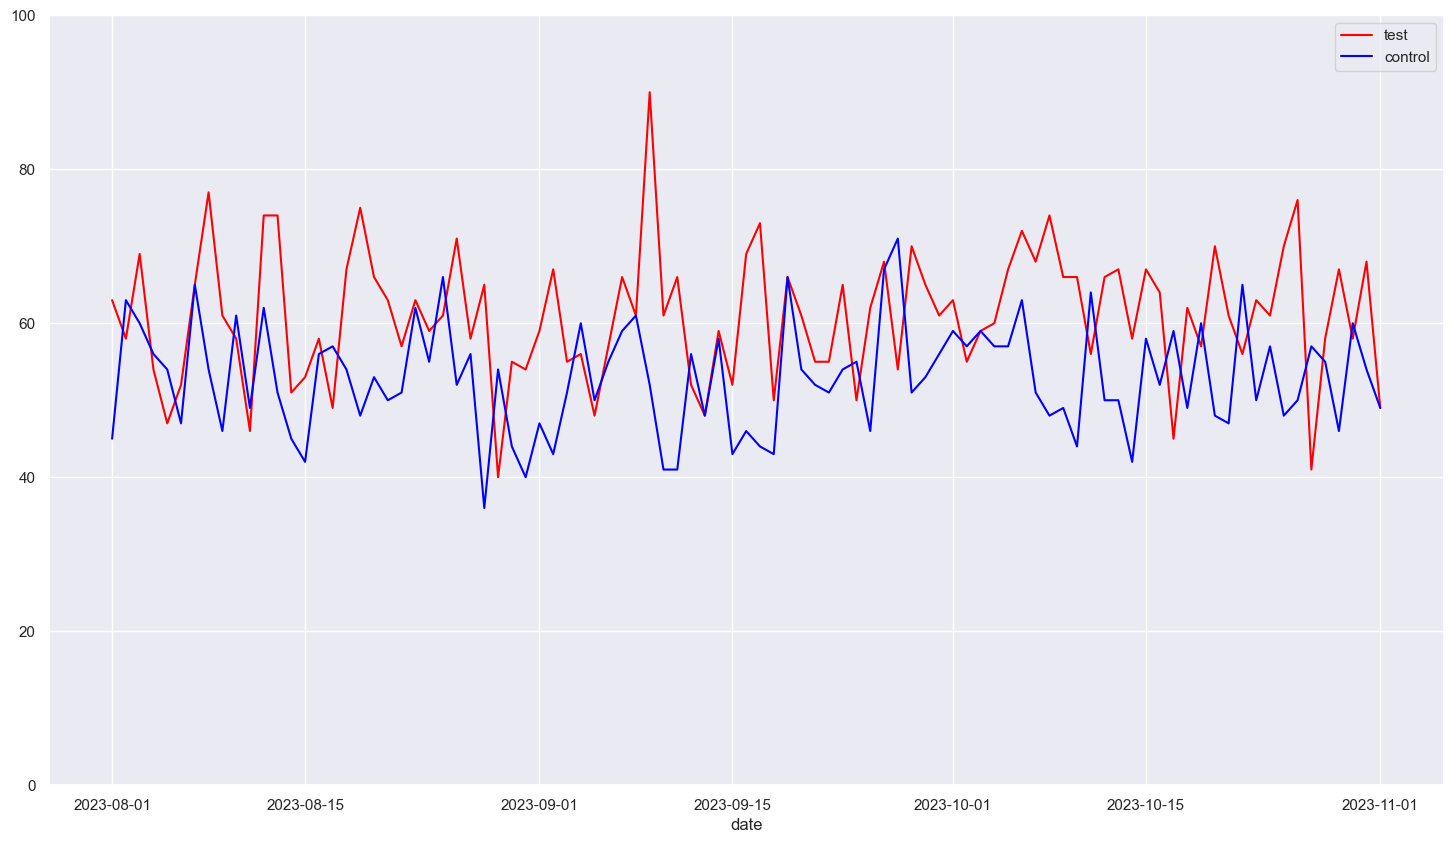

In [120]:
# построим график, отражающий количество оформленных карт по дням
fig, ax = plt.subplots(figsize=(18, 10))

sns.lineplot(data=test_n_by_date, ax=ax, palette=['red'], legend=False, label='test')
sns.lineplot(data=control_n_by_date, ax=ax, palette=['blue'], legend=False, label='control')

ax.legend()
ax.set_ylim(0, 100)

(0.0, 0.2)

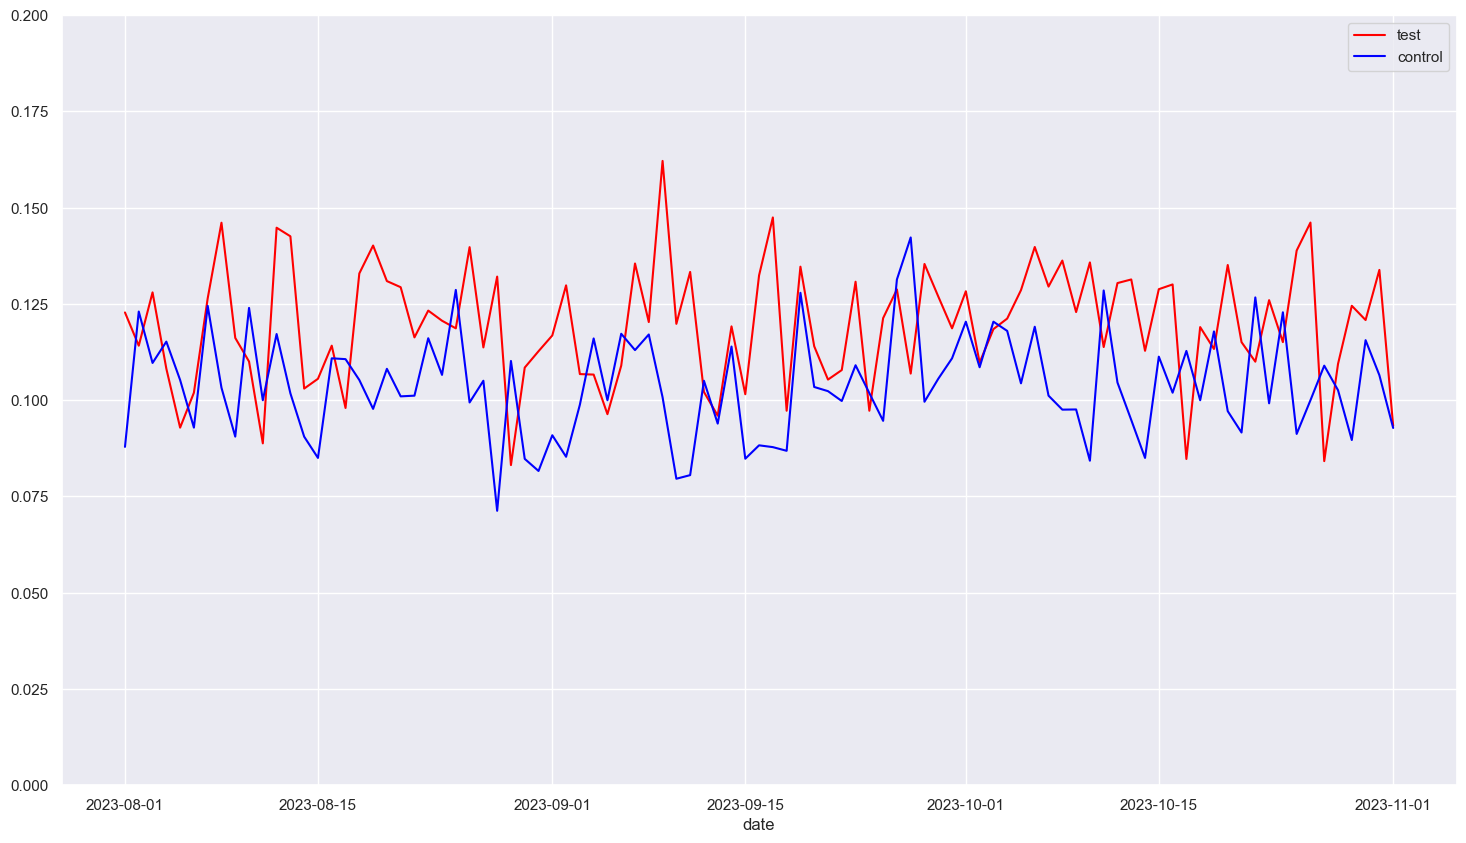

In [121]:
# построим график, отражающий конверсию из посещений в оформленние карт по дням

fig, ax = plt.subplots(figsize=(18, 10))

sns.lineplot(data=test_conv_by_date, ax=ax, palette=['red'], legend=False, label='test')
sns.lineplot(data=control_conv_by_date, ax=ax, palette=['blue'], legend=False, label='control')

ax.legend()
ax.set_ylim(0, 0.2)

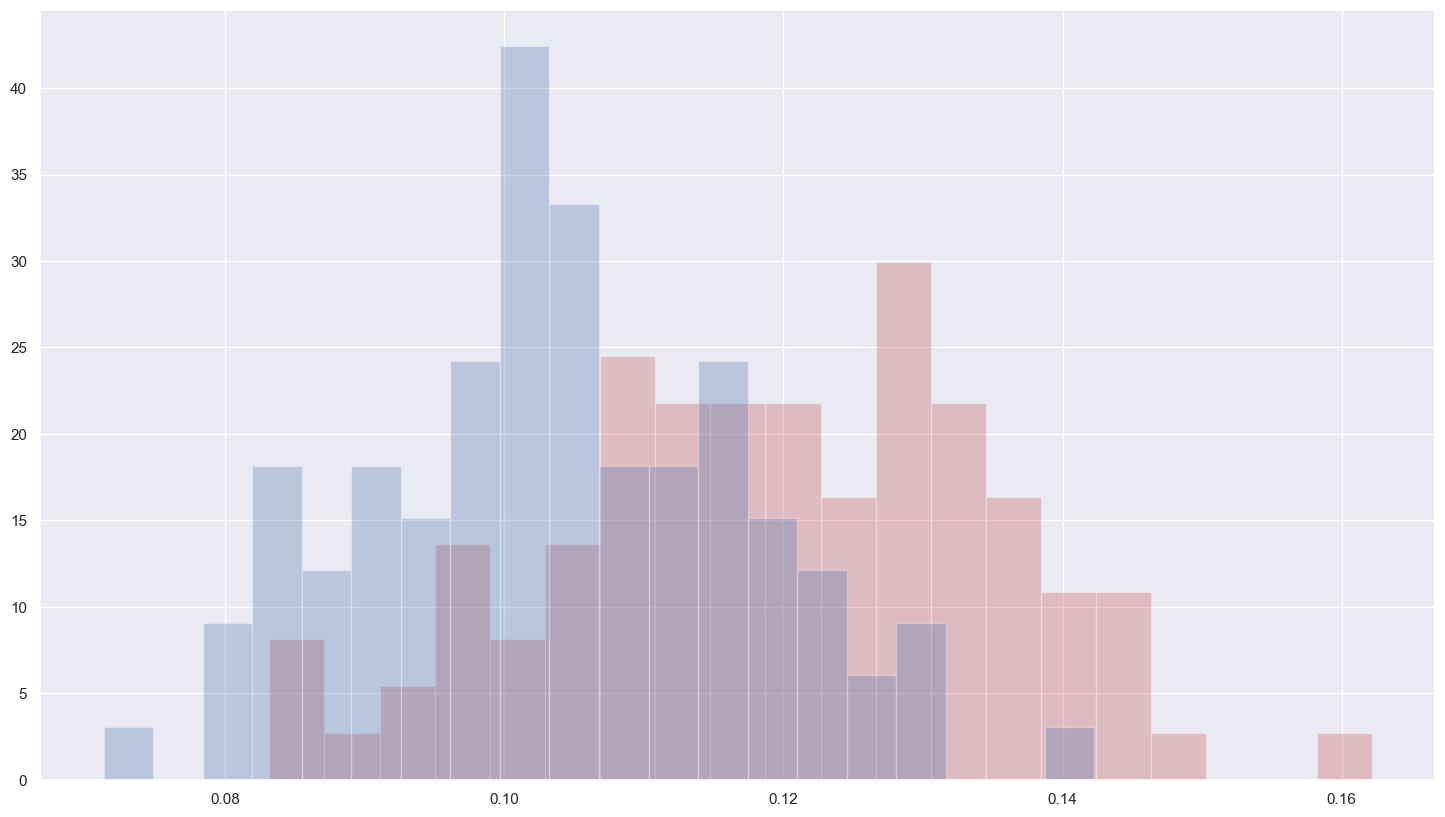

In [124]:
# построим распределения средних значений по дням в тесте и в контроле
# на что похоже это распределение?

fig, ax = plt.subplots(figsize=(18, 10))

ax.hist(test_conv_by_date, 20, density=True,color='r', alpha=0.3)
ax.hist(control_conv_by_date, 20, density=True,color='b', alpha=0.3);

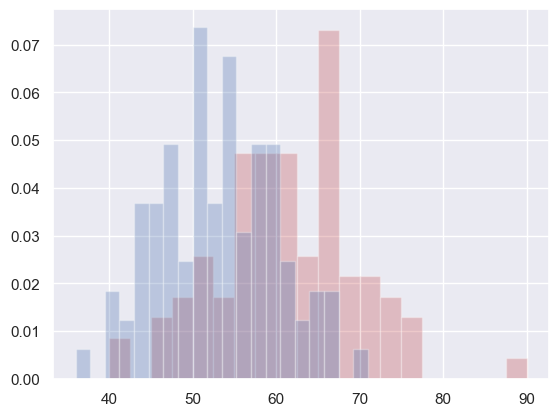

In [127]:
fig, ax = plt.subplots()

ax.hist(test_n_by_date, 20, density=True, color='r', alpha=0.3)
ax.hist(control_n_by_date, 20, density=True, color='b', alpha=0.3);

In [130]:
# теперь используем знание о том, что средние конверсии распределены нормально
# используйте статистический тест и проинтерпретируйте результаты
# как меняется ваш результат в зависимости от принятого вами уровня значимости?

from scipy.stats import ttest_ind

ttest_ind(test_conv_by_date, control_conv_by_date, equal_var=False, alternative='greater') # используйте документацию, test_conv_by_date, control_conv_by_date, чтобы провести тест


TtestResult(statistic=array([7.20902962]), pvalue=array([7.50432607e-12]), df=array([179.99001164]))

In [132]:
# используйте тот же статистический тест, чтобы оценить, отличаются ли  и проинтерпретируйте результаты
# как меняется ваш результат в зависимости от принятого вами уровня значимости?

ttest_ind(test_n_by_date, control_n_by_date, equal_var=False, alternative='greater')

TtestResult(statistic=array([7.04811343]), pvalue=array([1.93822691e-11]), df=array([177.39785874]))